# Music Lyrics Through the Years

#### Import (possibly) necessary libraries

In [156]:
import pandas as pd; pd.options.display.max_rows = 200
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

import re
from unicodedata import normalize

import requests as rq
from bs4 import BeautifulSoup as bs
from selenium import webdriver

import pickle
import gzip

from functions.webscraping import *

import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Scrape song title and artist

In [2]:
%%time

# list of unique songs in top 10 between 1960 and 2019
all_top10s = [
    yearly_top10s(f'https://top40weekly.com/{year}-all-charts/') for year in range(1960,2020)
]

len(all_top10s)

CPU times: user 14.3 s, sys: 172 ms, total: 14.4 s
Wall time: 1min 32s


60

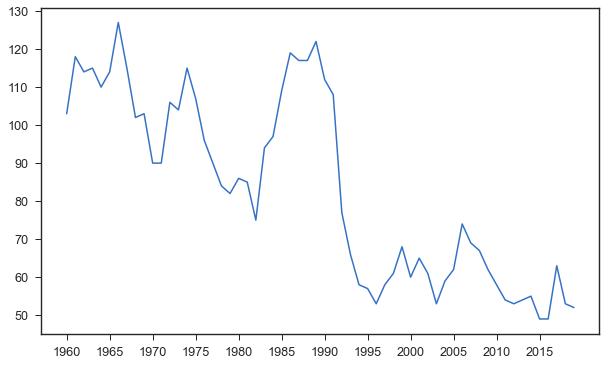

In [3]:
# graph number of unique songs per year
plt.figure(figsize=(10,6))
plt.plot([len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

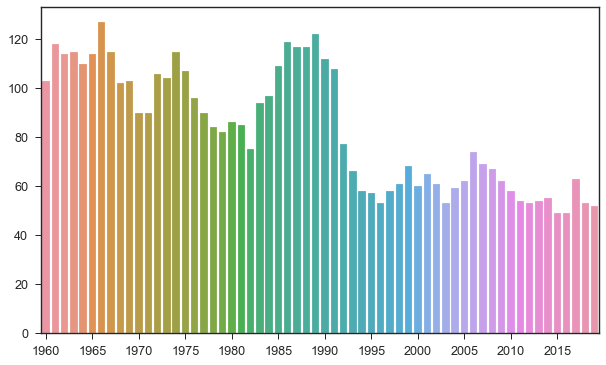

In [4]:
# graph number of unique songs per year
plt.figure(figsize=(10,6))
sns.barplot(x=[year for year in range(1960,2020)], y=[len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

In [5]:
# number of songs
sum([len(year) for year in all_top10s])

4996

- Since some songs may be within the top 10 in two different years, I need to remove those from the list.

In [6]:

temp_dict = {}

for i,year in enumerate(all_top10s):
    for song in year:
        if song in temp_dict:
            print(song)
            all_top10s[i].remove(song)
            
        else:
            temp_dict[song] = 1
            
len(temp_dict)

('SAILOR (Your Home Is the Sea)', 'Lolita')
('YOU’RE SIXTEEN', 'Johnny Burnette')
('MANY TEARS AGO', 'Connie Francis')
('NORTH TO ALASKA', 'Johnny Horton')
('THE TWIST', 'Chubby Checker')
('WONDERLAND BY NIGHT', 'Bert Kaempfert')
('A THOUSAND STARS', 'Kathy Young and the Innocents')
('LAST DATE', 'Floyd Cramer')
('EXODUS', 'Ferrante and Teicher')
('GOODBYE CRUEL WORLD', 'James Darren')
('RUN TO HIM', 'Bobby Vee')
('WALK ON BY', 'Leroy Van Dyke')
('THE TWIST', 'Chubby Checker')
('HAPPY BIRTHDAY, SWEET SIXTEEN', 'Neil Sedaka')
('PEPPERMINT TWIST (Part 1)', 'Joey Dee and the Starliters')
('THE LION SLEEPS TONIGHT', 'The Tokens')
('HOTEL HAPPINESS', 'Brook Benton')
('ZIP-A-DEE DOO-DAH', 'Bob B')
('LIMBO ROCK', 'Chubby Checker')
('GO AWAY LITTLE GIRL', 'Steve Lawrence')
('BOBBY’S GIRL', 'Marcie Blane')
('TALK BACK TREMBLING LIPS', 'Johnny Tillotson')
('DOMINIQUE', 'The Singing Nun')
('POPSICLES AND ICICLES', 'The Murmaids')
('SINCE I FELL FOR YOU', 'Lenny Welch')
('FORGET HIM', 'Bobby Rydel

4118

In [7]:
# number of unique songs
sum([len(year) for year in all_top10s])

4555

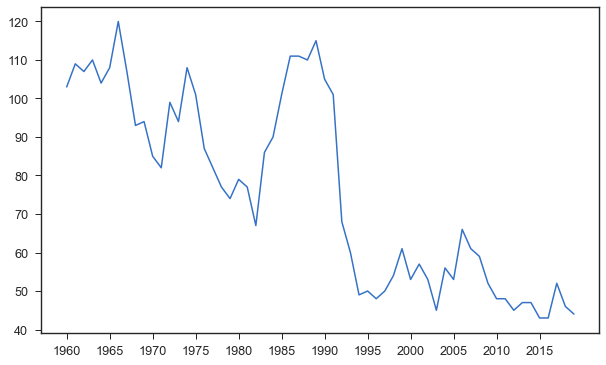

In [8]:
plt.figure(figsize=(10,6))
plt.plot([len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

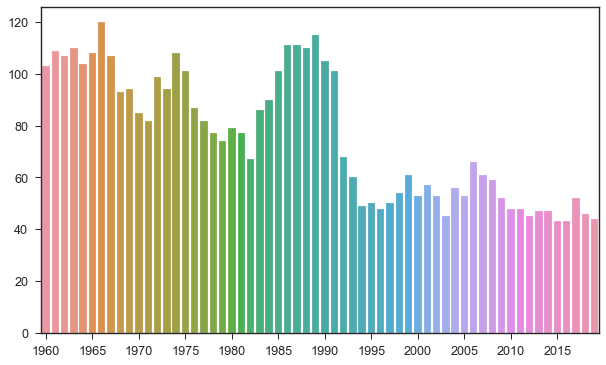

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(x=[year for year in range(1960,2020)], y=[len(year) for year in all_top10s])
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5))
plt.show()

## Scrape lyrics

In [10]:
# parse personal api keys
with open('data/api_keys.json', 'r') as json_file:
    creds = json.load(json_file)

# set the credentials based on the credentials file
client_id = creds['client_id']
client_secret = creds['client_secret']
access_token = creds['access_token']

In [11]:
%%time

top10s = []

for i,year in enumerate(all_top10s):
    
    print('\n' + str(i+1960))
    
    for song in year:
        
        song_dict = {}
        song_dict['year'] = i+1960
        song_dict['title'] = song[0]
        song_dict['artist'] = song[1]
        search_term = f'{song[0]} {song[1]}'
        
        try:
            song_dict['lyrics'] = lyrics_grabber(access_token, search_term)
            
        except:
            try:
                search_term = f"{re.match('[A-Z ]+', song[0]).group()} {' '.join(song[1].split()[:2])}"
                song_dict['lyrics'] = lyrics_grabber(access_token, search_term)
                                                                                 
            except:
                print(f'  {search_term}')
                song_dict['lyrics'] = np.nan
                                                                                 
        top10s.append(song_dict)
        
len(top10s)


1960

1961

1962

1963
  (Down At) PAPA JOE’S The Dixiebelles

1964

1965

1966

1967
  AN OPEN LETTER TO MY TEENAGE SON Victor Lundberg

1968

1969

1970
  MIDNIGHT COWBOY Ferrante and

1971

1972
  JUNGLE FEVER The Chakachas

1973

1974

1975

1976

1977

1978

1979

1980

1981

1982

1983

1984

1985

1986

1987

1988

1989

1990

1991

1992

1993

1994

1995

1996

1997

1998

1999

2000

2001

2002

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016
  JUJU ON DAT BEAT  Zayion McCall

2017

2018

2019
CPU times: user 5min 33s, sys: 14.6 s, total: 5min 47s
Wall time: 1h 55min 43s


4555

In [12]:
df = pd.DataFrame(top10s)
df.shape

(4555, 4)

In [13]:
df.head()

,year,title,artist,lyrics
0,1960,PAPER ROSES,Anita Bryant,I realize the way your eyes deceived me\nWith ...
1,1960,HE’LL HAVE TO GO,Jim Reeves,[Verse 1]\nPut your sweet lips a little closer...
2,1960,O DIO MIO,Annette,"[Strofa 1]\nE un giorno lui mi disse: ""Nei tuo..."
3,1960,YOGI,The Ivy Three,[Chorus]\nI got bitches on the side but she st...
4,1960,KIDDIO,Brook Benton,"I told you, baby, how I feel\nOne word can clo..."


In [14]:
df.tail()

,year,title,artist,lyrics
4550,2019,TALK,Khalid,[Chorus]\nCan we just talk? Can we just talk?\...
4551,2019,MIDDLE CHILD,J,"[Intro]\nYou good, T-Minus?\n\n[Refrain]\nNigg..."
4552,2019,I DON’T CARE,Ed Sheeran,[Verse 1: Ed Sheeran]\nI'm at a party I don't ...
4553,2019,TRUTH HURTS,Lizzo,[Intro]\nWhy men great 'til they gotta be grea...
4554,2019,PANINI,Lil Nas X,[Intro: Nessly]\nD-D-Daytrip took it to ten (H...


### Remove brackets and words contained within
- These tend to be denoting verse from chorus (or something similar) or other non-lyric words.

In [184]:
df['lyrics'] = df.lyrics.map(remove_brackets)

### Save/Load

In [199]:
# uncomment to save
with gzip.open('data/lyrics_df.pkl', 'wb') as goodbye:
    pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/lyrics_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

## Rescrapes

#### 1960

In [39]:
url = 'https://www.lyricsmode.com/lyrics/t/the_ivy_three/yogi.html'
page = rq.get(url)
soup = bs(page.content, 'html.parser')
df.loc[3, 'lyrics'] = '\n'.join(
    [line.strip() for line in soup.find('div', attrs={'id': 'lyrics_text'}).contents
     if isinstance(line, str) if line.strip()]
)
df.head()

,year,title,artist,lyrics
0,1960,PAPER ROSES,Anita Bryant,I realize the way your eyes deceived me\nWith ...
1,1960,HE’LL HAVE TO GO,Jim Reeves,[Verse 1]\nPut your sweet lips a little closer...
2,1960,O DIO MIO,Annette,"[Strofa 1]\nE un giorno lui mi disse: ""Nei tuo..."
3,1960,YOGI,The Ivy Three,"I saw a kook, who was standing on his head\nHe..."
4,1960,KIDDIO,Brook Benton,"I told you, baby, how I feel\nOne word can clo..."


In [42]:
df.loc[51, 'lyrics'] = lyrics_grabber(access_token, search_term="because they're young duane eddy and the rebels")

In [55]:
url = 'https://www.stlyrics.com/lyrics/heartsinatlantis/themefromasummerplace.htm'
page = rq.get(url)
soup = bs(page.content, 'html.parser')
df.loc[57, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find_all('div', class_='highlight') if line.contents]
)
df.loc[57, 'lyrics']

"There's a summer place\nWhere it may rain or storm\nYet I'm safe and warm\nFor within that summer place\nYour arms reach out to me\nAnd my heart is free from all care\nFor it knows\nThere are no gloomy skies\nWhen seen through the eyes\nOf those who are blessed with love\nAnd the sweet secret of\nA summer place\nIs that it's anywhere\nWhen two people share\nAll their hopes\nAll their dreams\nAll their love\nThere's a summer place\nWhere it may rain or storm\nYet I'm safe and warm\nIn your arms, in your arms\nIn your arms, in your arms\nIn your arms, in your arms"

In [80]:
url = 'https://mojim.com/usy155738x2x2.htm'
page = rq.get(url)
soup = bs(page.content, 'html.parser')

df.loc[101, 'lyrics'] = '\n'.join(
    [line for line in soup.find('dl', attrs={'id': 'fsZx1'}).contents[6:]
     if isinstance(line, str) if line.strip()]
)

df.loc[101, 'lyrics']

"This land is mine, God gave this land to me\nThis brave and ancient land to me\nAnd when the morning sun reveals her hills and plain\nThen I see a land where children can run free\nSo take my hand and walk this land with me\nAnd walk this lovely land with me\nThough I am just a man, when you are by my side\nWith the help of God, I know I can be strong\nThough I am just a man, when you are by my side\nWith the help of God, I know I can be strong\nTo make this land our home\nIf I must fight, I'll fight to make this land our own\nUntil I die, this land is mine"

#### 1961

In [146]:
# instrumentals
df.loc[113, 'lyrics'] = np.nan
df.loc[142, 'lyrics'] = np.nan
df.loc[159, 'lyrics'] = np.nan
df.loc[191, 'lyrics'] = np.nan

In [103]:
url = 'https://www.flashlyrics.com/lyrics/ferrante-and-teicher/tonight-12'
page = rq.get(url)
soup = bs(page.content, 'html.parser')
df.loc[123, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')
     if line.contents]
)

In [98]:
soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')

[<span>Tonight, tonight, won't be just any night</span>,
 <span>Tonight there will be no morning star</span>,
 <span></span>,
 <span>Tonight, tonight, I'll see my love tonight</span>,
 <span>And for us, stars will stop where they are</span>,
 <span>Today, the minutes seem like hours</span>,
 <span>The hours go so slowly</span>,
 <span>And still the sky is light</span>,
 <span>Oh moon, grow bright and make this endless day</span>,
 <span>Endless night, tonight</span>,
 <span></span>,
 <span>Today, the world was just an adress</span>,
 <span>A place for me to live in</span>,
 <span>No better than all right.</span>,
 <span></span>,
 <span>But here you are, and what was just a world</span>,
 <span>Is a star, tonight</span>]

In [132]:
# remove first four lines
df.loc[131, 'lyrics'] = remove_n_lines(4, df.loc[131, 'lyrics'])

In [140]:
# update name and remove first three lines
df.loc[164, 'artist'] = 'The String-A-Longs'
df.loc[164, 'lyrics'] = remove_n_lines(3, df.loc[164, 'lyrics'])

In [144]:
# remove first 7 lines
df.loc[168, 'lyrics'] = remove_n_lines(7, df.loc[168, 'lyrics'])

In [151]:
# rescrape (bad interaction with "Group")
df.loc[192, 'lyrics'] = lyrics_grabber(access_token, 'arthur lyman yellow bird')

In [159]:
# rescrape
df.loc[211, 'lyrics'] = rescrape('https://www.songfacts.com/lyrics/dick-dee-dee/the-mountains-high',
                                 soup.find('div', attrs={'class': 'inner'}).contents)

### 1962

In [167]:
# instrumentals
df.loc[212, 'lyrics'] = np.nan
df.loc[215, 'lyrics'] = np.nan
df.loc[223, 'lyrics'] = np.nan
df.loc[254, 'lyrics'] = np.nan
df.loc[266, 'lyrics'] = np.nan
df.loc[268, 'lyrics'] = np.nan
df.loc[297, 'lyrics'] = np.nan

In [166]:
# rescrape (bad interaction)
df.loc[310, 'lyrics'] = lyrics_grabber(access_token, 'joey dee shout')

### 1963

In [187]:
# instrumentals
df.loc[338, 'lyrics'] = np.nan
df.loc[340, 'lyrics'] = np.nan
df.loc[356, 'lyrics'] = np.nan
df.loc[415, 'lyrics'] = np.nan
df.loc[421, 'lyrics'] = np.nan
df.loc[423, 'lyrics'] = np.nan

In [196]:
# rescrape (bad interaction)
df.loc[348, 'lyrics'] = lyrics_grabber(access_token, 'fingertips stevie')

In [197]:
# remove first 2 lines
df.loc[368, 'lyrics'] = remove_n_lines(2, df.loc[368, 'lyrics'])

In [198]:
# remove first 2 lines
df.loc[388, 'lyrics'] = remove_n_lines(2, df.loc[388, 'lyrics'])

In [193]:
# remove duplicate
df.drop(index=427, inplace=True)

### 1964

In [200]:
df[df.year == 1964]

,year,title,artist,lyrics
429,1964,YOU DON’T OWN ME,Lesley Gore,You don't own me\nI'm not just one of your man...
430,1964,WHERE DID OUR LOVE GO,The Supremes,"Baby, baby\nBaby don't leave me\nOoh, please d..."
431,1964,FOR YOU,Rick Nelson,"I will gather stars out of the blue\nFor you, ..."
432,1964,I FEEL FINE,The Beatles,"Baby's good to me, you know\nShe's happy as ca..."
433,1964,REMEMBER (Walkin’ In the Sand),The Shangri,Seems like the other day\nMy baby went away\nH...
434,1964,THE NITTY GRITTY,Shirley Ellis,"Some folks know about it, some don't \nSome wi..."
435,1964,RAG DOLL,The Four Seasons,"Ooh, oo-oo-oo-ooh \nOoh-oo-oo-oo-oo-oo-oo-ooh\..."
436,1964,WHITE ON WHITE,Danny Williams,"White on white, lace on satin\nBlue velvet rib..."
437,1964,BITS AND PIECES,The Dave Clark Five,Since you left me and you said goodbye\n\nAll ...
438,1964,SURFIN’ BIRD,The Trashmen,A well a everybody's heard about the bird\nB-b...


In [194]:
# remove duplicate
df[df.artist == 'The Four Seasons']

,year,title,artist,lyrics
259,1962,SHERRY,The Four Seasons,"Sherry, Sherry baby\nSherry, Sherry baby\n\nSh..."
316,1962,BIG GIRLS DON’T CRY,The Four Seasons,Big girls don't cry \nBig girls don't cry \nMy...
320,1963,WALK LIKE A MAN,The Four Seasons,"Walk like a man\n\nOh, how you tried to cut me..."
329,1963,CANDY GIRL,The Four Seasons,I've been a-searchin' all this wide world\nNow...
435,1964,RAG DOLL,The Four Seasons,"Ooh, oo-oo-oo-ooh \nOoh-oo-oo-oo-oo-oo-oo-ooh\..."
452,1964,RONNIE,The Four Seasons,I'll go on living and keep on forgiving\nBecau...
500,1964,SAVE IT FOR ME,The Four Seasons,"Ahhhh\nDon't let your love go astray, save it ..."
514,1964,DAWN (Go Away),The Four Seasons,Pretty as a midsummer's morn\nThey call her Da...
536,1965,LET’S HANG ON,The Four Seasons,There ain't no good in our goodbye-in'\nTrue l...
644,1966,I’VE GOT YOU UNDER MY SKIN,The Four Seasons,I've got you under my skin\nI've got you deep ...


In [186]:
print(df.loc[421, 'lyrics'])

CHAPTER XIX.

PROVERBS.

In the present chapter are collected together the chief proverbs either quoted or alluded to by Shakespeare. Many of these are familiar to most readers, but have gained an additional interest by reason of their connection with the poet's writings. At the same time, it may be noted, that very many of Shakespeare's pithy sayings have since his day passed into proverbs, and have taken their place in this class of literature. It is curious to notice, as Mrs Cowden Clarke remarks,  how "Shakespeare has paraphrased some of our commonest proverbs in his own choice and elegant diction." Thus, "make hay while the sun shines," becomes—

"The sun shines hot; and if we use delay,
Cold biting winter mars our hoped-for hay,"

a statement which applies to numerous other proverbial sayings.

"A black man is a jewel in a fair woman's eyes."—In the "Two Gentlemen of Verona" , the following passage is an amusing illustration of the above:—

"Thurio. What says she to my face?
Prot

In [155]:
'\n'.join(
    [line.strip() for line in soup.find('div', attrs={'class': 'inner'}).contents
     if isinstance(line, str) if line.strip()]
)

"Yeah, yeah, yeah\nThe mountain's high\nAnd the valley's so deep\nCan't get across\nTo the other side\nDon't you give up, baby\nDon't you cry\nDon't you give up til\nI reach the other side\nI was lonely, baby\nI couldn't sleep\nThe night they took you\nFrom my side\nI was a lonely soul\nUntil you became my goal\nAnd then I saw the spark of love\nAnd then the stars fell\nFrom up above, oh, yeah\nI know someday\nWe will meet again\nBut I don't know exactly\nWhere or when\nBut, baby, if fate has its way\nWe'll meet again some other day\nThe mountain's high\nAnd the valley's so deep\nCan't get across\nTo the other side\nDon't you give up, baby\nDon't you cry\nDon't you give up til\nI reach the other side"

In [154]:
soup.find('div', attrs={'class': 'inner'}).contents

['\n                                                  Yeah, yeah, yeah',
 <br/>,
 <br/>,
 "The mountain's high",
 <br/>,
 "And the valley's so deep",
 <br/>,
 "Can't get across",
 <br/>,
 'To the other side',
 <br/>,
 <br/>,
 "Don't you give up, baby",
 <br/>,
 "Don't you cry",
 <br/>,
 "Don't you give up til",
 <br/>,
 'I reach the other side',
 <br/>,
 <br/>,
 'I was lonely, baby',
 <br/>,
 "I couldn't sleep",
 <br/>,
 'The night they took you',
 <br/>,
 'From my side',
 <br/>,
 <br/>,
 'I was a lonely soul',
 <br/>,
 'Until you became my goal',
 <br/>,
 'And then I saw the spark of love',
 <br/>,
 'And then the stars fell',
 <br/>,
 'From up above, oh, yeah',
 <br/>,
 <br/>,
 'I know someday',
 <br/>,
 'We will meet again',
 <br/>,
 "But I don't know exactly",
 <br/>,
 'Where or when',
 <br/>,
 <br/>,
 'But, baby, if fate has its way',
 <br/>,
 "We'll meet again some other day",
 <br/>,
 <br/>,
 "The mountain's high",
 <br/>,
 "And the valley's so deep",
 <br/>,
 "Can't get across",

In [ ]:
please break this code

In [120]:
print(df.loc[81, 'lyrics'])

Teen Angel
Teen Angel
Teen Angel

VERSE 1
That fateful night the car was stalled
Upon the railroad track
I pulled you out and we were safe
But you went running back

CHORUS
Teen angel
Can you hear me?
Teen angel
Can you see me?
Are you somewhere up above?
And am I still your own true love?

VERSE 2
What was it you were looking for
That took your life that night
They said they found my high school ring
Clutched in your fingers tight

CHORUS

VERSE 3
Just sweet sixteen, and now you're gone
They've taken you away
I'll never kiss your lips again
They buried you today

CHORUS

Teen angel
Teen angel
Answer me please


In [109]:
regex = re.compile(".*?\[(.*?)\]")
result = re.findall(regex, df.loc[1, 'lyrics'])
result

['Verse 1', 'Verse 2', 'Bridge', 'Verse 1']

In [119]:
df['lyrics'] = df.lyrics.map(remove_brackets)
df.lyrics.head(100)

0     I realize the way your eyes deceived me\nWith ...
1     Put your sweet lips a little closer to the pho...
2     E un giorno lui mi disse: "Nei tuoi occhi vedo...
3     I saw a kook, who was standing on his head\nHe...
4     I told you, baby, how I feel\nOne word can clo...
5     Hoh ah, hoh, I hear something saying\nHoh ah, ...
6     Georgia\nGeorgia\nThe whole day through\n\nJus...
7     Comma, comma, comma, comma, come, come, comma\...
8     In every other song that I've heard lately\nSo...
9     You can shake an apple off an apple tree\nShak...
10    The sweet things you do to me like holding my ...
11    It seems we stood and talked like this before\...
12    Ueber Rio und Shanghai\nUeber Bali und Hawaii\...
13    Don't want your love any more\nDon't want your...
14    Climb up way up high\nClimb up way up high\nCl...
15    Oh, come along with me\nTo my little corner of...
16    In May of 1941 the war had just begun\nThe Ger...
17    Well, way down yonder in New Orleans\nIn t